# **_Entrega 8_**

_Pablo Martín de Benito_

---

Clasificación de imágenes:
– Dataset: MNIST FASHION incluida en PyTorch 

– Arquitectura VGG:

● CNN(1,16) + CNN(16,32) + MaxPool(2)

● CNN(32,64) + CNN(64,128) + MaxPool(2)

● MLP(¿?, 128, 10)

– Tamaño de bandeja: 32

– Función de pérdida: Entropía Cruzada

– Optimizador: Adagrad (tasa de aprendizaje adaptativo)

– Épocas:20

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adagrad
from torch.nn import CrossEntropyLoss
from copy import deepcopy as dc
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


In [2]:
train_set = torchvision.datasets.FashionMNIST(root = './data/FashionMNIST', download = True, train = True,
 transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST(root = './data/FashionMNIST', download=True, train=False,
 transform = transforms.Compose([transforms.ToTensor()]))

In [3]:
bandeja = 32
train_loader = torch.utils.data.DataLoader(train_set,shuffle=True, batch_size=bandeja)
train_accuracy_loader = torch.utils.data.DataLoader(train_set, batch_size=60000)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=10000)

In [5]:
train_images = torch.zeros((len(train_set), 28*28), dtype=torch.float32)
train_labels = torch.empty(len(train_set), dtype=torch.long)
for i, muestra in enumerate(train_set):
 train_images[i] = torch.flatten(muestra[0])
 train_labels[i] = muestra[1]

In [6]:
class Network(nn.Module):
 def __init__(self):
    super(Network,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)

    self.relu = nn.LeakyReLU()

    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.fc1 = nn.Linear(in_features=4*4*128,out_features=128)
    self.out = nn.Linear(in_features=128,out_features=10)

 def forward(self,x):
    #first CNN layer
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    #second CNN layer
    x = self.conv3(x)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.pool(x)

    #mlp hidden layer
    x = torch.flatten(x, start_dim=1)
    x = self.fc1(x)
    x = self.relu(x)

    #output layer
    x = self.out(x)
    return x

In [7]:
model = Network().to(device)
xx, yy = next(iter(train_loader))
# Si ponemos xx.to(device) podemos pasarlo a la GPU.
x1 = model.pool(model.relu(model.conv2(model.relu(model.conv1(xx.to(device))))))
x2 = model.pool(model.relu(model.conv4(model.relu(model.conv3(x1)))))
x2.shape

torch.Size([32, 128, 4, 4])

In [8]:
summary(model, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
         LeakyReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
         LeakyReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 64, 10, 10]          18,496
         LeakyReLU-7           [-1, 64, 10, 10]               0
            Conv2d-8            [-1, 128, 8, 8]          73,856
         LeakyReLU-9            [-1, 128, 8, 8]               0
        MaxPool2d-10            [-1, 128, 4, 4]               0
           Linear-11                  [-1, 128]         262,272
        LeakyReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 360,714
Trainable params:

In [9]:
X_train, y_train = next(iter(train_accuracy_loader))
X_test, y_test = next(iter(test_loader))

In [10]:
epochs = 20
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
learning_rate = []
optimizer = Adagrad(model.parameters())
criterion = CrossEntropyLoss()

for i in range(epochs):
    print("Epoch: ", i)
    model.train(True)
    for images,targets in tqdm(train_loader):
        #making predictions
        y_pred = model(images.to(device))
        #calculating loss
        loss = criterion(y_pred,targets.long().to(device))    #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        y_train_pred = model(X_train.to(device))
        train_accuracy.append(np.mean((y_train == y_train_pred.cpu().argmax(dim=1)).numpy()))
        train_loss.append(criterion(y_train_pred.cpu(), y_train.long()).numpy())
    print('Train Loss: {0:.5f}'.format(train_loss[-1]), '\tTrain Accuracy: {0:.5f}'.format(train_accuracy[-1]))

    with torch.no_grad():
        y_test_pred = (model(X_test.to(device)))
        test_accuracy.append(np.mean((y_test == y_test_pred.cpu().argmax(dim=1)).numpy()))
        test_loss.append(criterion(y_test_pred.cpu(), y_test.long()).numpy())
        learning_rate.append(optimizer.param_groups[0]['lr'])
    print(' Val Loss: {0:.5f}'.format(test_loss[-1]), '\t Test Accuracy: {0:.5f}'.format(test_accuracy[-1]), "\tLearning Rate:", learning_rate[-1])

Epoch:  0


100%|██████████| 1875/1875 [00:23<00:00, 79.78it/s]


Train Loss: 0.35777 	Train Accuracy: 0.86815
 Val Loss: 0.38273 	 Test Accuracy: 0.85700 	Learning Rate: 0.01
Epoch:  1


100%|██████████| 1875/1875 [00:24<00:00, 75.87it/s]


Train Loss: 0.30397 	Train Accuracy: 0.88802
 Val Loss: 0.33344 	 Test Accuracy: 0.87760 	Learning Rate: 0.01
Epoch:  2


100%|██████████| 1875/1875 [00:23<00:00, 78.18it/s]


Train Loss: 0.27776 	Train Accuracy: 0.89712
 Val Loss: 0.31161 	 Test Accuracy: 0.88630 	Learning Rate: 0.01
Epoch:  3


100%|██████████| 1875/1875 [00:25<00:00, 73.76it/s]


Train Loss: 0.24540 	Train Accuracy: 0.90957
 Val Loss: 0.28138 	 Test Accuracy: 0.89620 	Learning Rate: 0.01
Epoch:  4


100%|██████████| 1875/1875 [00:23<00:00, 80.13it/s]


Train Loss: 0.22016 	Train Accuracy: 0.92050
 Val Loss: 0.26064 	 Test Accuracy: 0.90580 	Learning Rate: 0.01
Epoch:  5


100%|██████████| 1875/1875 [00:24<00:00, 76.41it/s]


Train Loss: 0.21002 	Train Accuracy: 0.92255
 Val Loss: 0.25763 	 Test Accuracy: 0.90550 	Learning Rate: 0.01
Epoch:  6


100%|██████████| 1875/1875 [00:24<00:00, 75.38it/s]


Train Loss: 0.20261 	Train Accuracy: 0.92515
 Val Loss: 0.25402 	 Test Accuracy: 0.90850 	Learning Rate: 0.01
Epoch:  7


100%|██████████| 1875/1875 [00:25<00:00, 72.79it/s]


Train Loss: 0.19196 	Train Accuracy: 0.92987
 Val Loss: 0.24619 	 Test Accuracy: 0.91270 	Learning Rate: 0.01
Epoch:  8


100%|██████████| 1875/1875 [00:23<00:00, 79.22it/s]


Train Loss: 0.18725 	Train Accuracy: 0.93018
 Val Loss: 0.24776 	 Test Accuracy: 0.90960 	Learning Rate: 0.01
Epoch:  9


100%|██████████| 1875/1875 [00:23<00:00, 81.07it/s]


Train Loss: 0.17429 	Train Accuracy: 0.93625
 Val Loss: 0.23707 	 Test Accuracy: 0.91530 	Learning Rate: 0.01
Epoch:  10


100%|██████████| 1875/1875 [00:25<00:00, 73.25it/s]


Train Loss: 0.17097 	Train Accuracy: 0.93773
 Val Loss: 0.23564 	 Test Accuracy: 0.91600 	Learning Rate: 0.01
Epoch:  11


100%|██████████| 1875/1875 [00:23<00:00, 78.56it/s]


Train Loss: 0.16218 	Train Accuracy: 0.94112
 Val Loss: 0.23525 	 Test Accuracy: 0.91770 	Learning Rate: 0.01
Epoch:  12


100%|██████████| 1875/1875 [00:23<00:00, 79.92it/s]


Train Loss: 0.16160 	Train Accuracy: 0.94043
 Val Loss: 0.23922 	 Test Accuracy: 0.91610 	Learning Rate: 0.01
Epoch:  13


100%|██████████| 1875/1875 [00:22<00:00, 82.13it/s]


Train Loss: 0.14546 	Train Accuracy: 0.94815
 Val Loss: 0.22955 	 Test Accuracy: 0.92040 	Learning Rate: 0.01
Epoch:  14


100%|██████████| 1875/1875 [00:23<00:00, 78.72it/s]


Train Loss: 0.15078 	Train Accuracy: 0.94413
 Val Loss: 0.24213 	 Test Accuracy: 0.91560 	Learning Rate: 0.01
Epoch:  15


100%|██████████| 1875/1875 [00:22<00:00, 81.84it/s]


Train Loss: 0.14284 	Train Accuracy: 0.94775
 Val Loss: 0.23425 	 Test Accuracy: 0.91980 	Learning Rate: 0.01
Epoch:  16


100%|██████████| 1875/1875 [00:22<00:00, 83.81it/s]


Train Loss: 0.13509 	Train Accuracy: 0.95140
 Val Loss: 0.23391 	 Test Accuracy: 0.91970 	Learning Rate: 0.01
Epoch:  17


100%|██████████| 1875/1875 [00:23<00:00, 80.29it/s]


Train Loss: 0.12811 	Train Accuracy: 0.95385
 Val Loss: 0.22874 	 Test Accuracy: 0.92130 	Learning Rate: 0.01
Epoch:  18


100%|██████████| 1875/1875 [00:22<00:00, 83.82it/s]


Train Loss: 0.12015 	Train Accuracy: 0.95725
 Val Loss: 0.23173 	 Test Accuracy: 0.92220 	Learning Rate: 0.01
Epoch:  19


100%|██████████| 1875/1875 [00:22<00:00, 81.64it/s]


Train Loss: 0.11441 	Train Accuracy: 0.95940
 Val Loss: 0.23352 	 Test Accuracy: 0.92110 	Learning Rate: 0.01


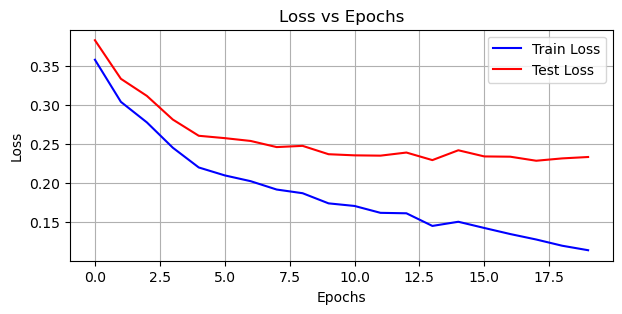

In [13]:
# Grafico de línea loss vs epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))
plt.plot(train_loss, linestyle='-',color='b', label='Train Loss')
plt.plot(test_loss, linestyle='-', color='r', label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

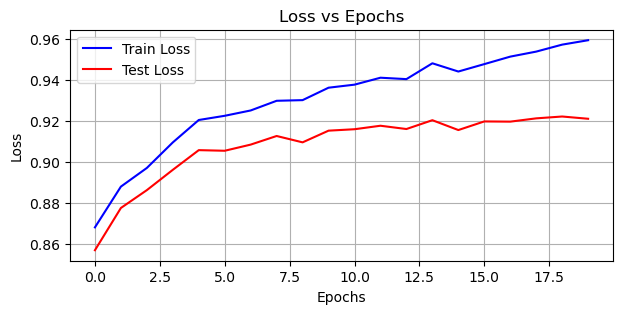

In [14]:
# Grafico accuracy
plt.figure(figsize=(7, 3))
plt.plot(train_accuracy, linestyle='-',color='b', label='Train Loss')
plt.plot(test_accuracy, linestyle='-', color='r', label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()